A collection of deep learning models in JAX.

*   Author: Tianlin Liu
*   GitHub Repository: https://github.com/liutianlin0121/jax-deep-learning-models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liutianlin0121/jax-deep-learning-models/blob/main/MLP/mlp-mnist.ipynb)


## Imports

In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install ml-collections -q
  !pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
  !pip install flax -q

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import ml_collections
import optax

import torchvision
from torch.utils import data

## Prepare the MNIST dataset

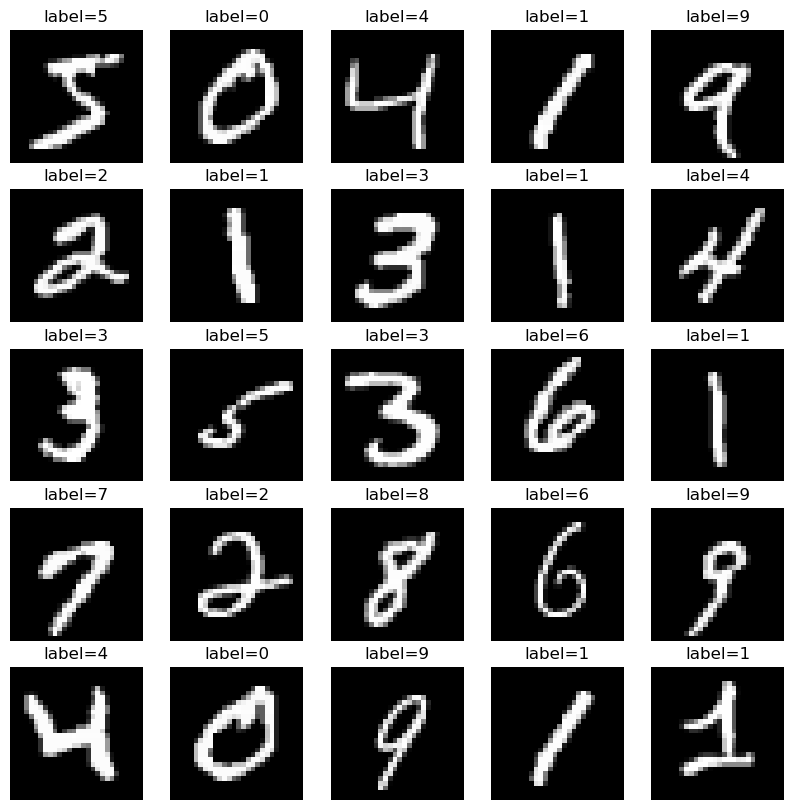

In [3]:
# Helper functions for images.
def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  if title:
    ax.set_title(title)


def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)


def numpy_collate(batch):
  """Stack data into a numpy array.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


class CastAndNormalize(object):
  """Cast and normalize an image.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32)) / 255

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=True,
    transform=CastAndNormalize(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=False,
    transform=CastAndNormalize(),
    download=True
)

show_img_grid(
  [train_dataset[idx][0].reshape((28, 28)) for idx in range(25)],
  [f'label={train_dataset[idx][1]}' for idx in range(25)],
)



## Set up the model and the training loop

The implementation here closely follows the example provided in the [flax repository](https://github.com/google/flax/tree/main/examples), sometimes verbatim.




In [4]:
class MLP(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=300)(x)
    x = nn.relu(x)
    x = nn.Dense(features=200)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x


@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, images)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(
      optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)


def train_epoch(state, train_loader):
  """Train for a single epoch."""

  epoch_loss = []
  epoch_accuracy = []

  for batch_images, batch_labels in train_loader:
    grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  mlp = MLP()
  params = mlp.init(rng, jnp.ones([1, 28 * 28]))['params']
  tx = optax.sgd(config.learning_rate, config.momentum)
  return train_state.TrainState.create(
    apply_fn=mlp.apply, params=params, tx=tx)


def train_and_evaluate(
  config: ml_collections.ConfigDict) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.

  Returns:
    The train state (which includes the `.params`).
  """
  # train_ds, test_ds = get_datasets()
  train_loader = data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=numpy_collate, drop_last=True)

  test_loader = data.DataLoader(
      test_dataset, batch_size=config.batch_size,
      shuffle=False, num_workers=4,
      collate_fn=numpy_collate, drop_last=True)

  rng = jax.random.PRNGKey(42)

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    rng, _ = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_loader)

    test_loss_total = 0.0
    test_acc_total = 0.0
    for images, labels in test_loader:
      _, test_loss_batch, test_accuracy_batch = apply_model(
        state, images, labels)
      test_loss_total += test_loss_batch
      test_acc_total += test_accuracy_batch

    test_loss = test_loss_total / len(test_loader)
    test_accuracy = test_acc_total / len(test_loader)
    print(f'epoch: {epoch:02d}/{config.num_epochs:02d} | train_loss: {train_loss:.4f} | ' +\
          f'train_accuracy: {train_accuracy * 100: .2f}  | ' +\
          f'test_loss: {test_loss: .4f}  | ' +\
          f'test_accuracy: {test_accuracy * 100:.2f}')

  return state

## Training

In [5]:
config = ml_collections.ConfigDict()

config.learning_rate = 0.1
config.momentum = 0.9
config.batch_size = 128
config.num_epochs = 5

state = train_and_evaluate(config)

epoch: 01/05 | train_loss: 0.2595 | train_accuracy:  92.22  | test_loss:  0.1149  | test_accuracy: 96.32
epoch: 02/05 | train_loss: 0.0943 | train_accuracy:  97.14  | test_loss:  0.0934  | test_accuracy: 97.08
epoch: 03/05 | train_loss: 0.0639 | train_accuracy:  97.99  | test_loss:  0.0716  | test_accuracy: 97.77
epoch: 04/05 | train_loss: 0.0460 | train_accuracy:  98.52  | test_loss:  0.0738  | test_accuracy: 97.85
epoch: 05/05 | train_loss: 0.0346 | train_accuracy:  98.86  | test_loss:  0.0639  | test_accuracy: 98.15


## Inference

In [6]:
test_images = jnp.array([test_data[0] for test_data in test_dataset])
test_labels = jnp.array([test_data[1] for test_data in test_dataset])

# Find all mistakes in testset.
logits = MLP().apply({'params': state.params}, test_images)
error_idxs, = jnp.where(test_labels != logits.argmax(axis=1))
correct_idxs, = jnp.where(test_labels == logits.argmax(axis=1))


print(len(error_idxs) / len(logits))

0.0185


### Show some correctly classified digits

Text(0.5, 0.95, 'Examples of correctly classified digits')

<Figure size 640x480 with 0 Axes>

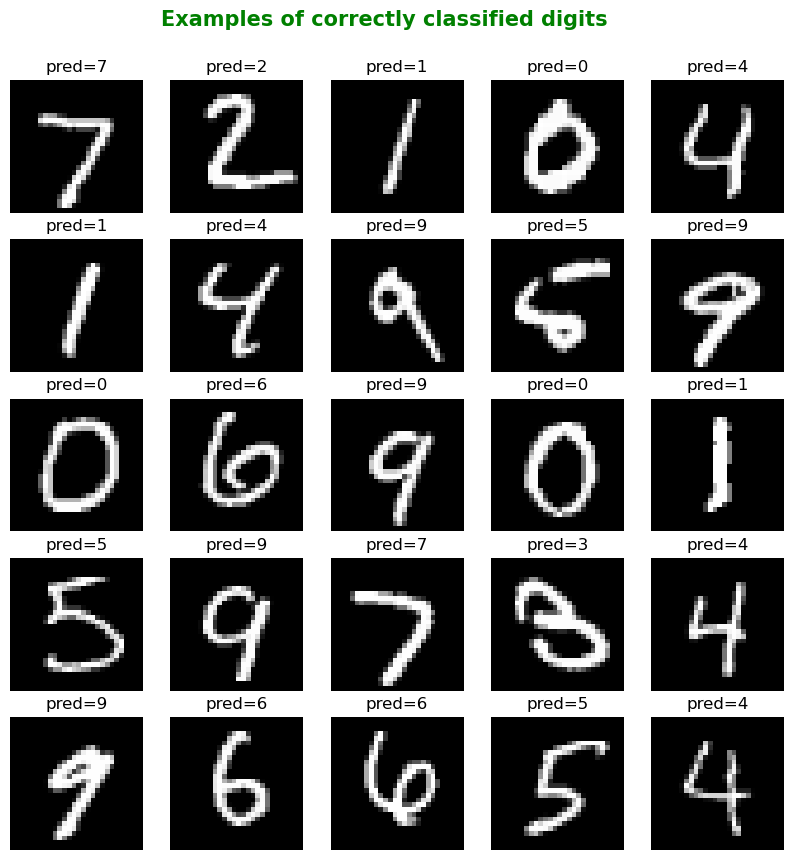

In [7]:
plt.figure()
show_img_grid(
    [test_images[idx].reshape((28, 28)) for idx in correct_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in correct_idxs[:25]],
)
plt.suptitle("Examples of correctly classified digits",
             y=0.95, fontsize=15, c='g', fontweight="bold")

### Show some wrongly classified digits

Text(0.5, 0.95, 'Examples of wrongly classified digits')

<Figure size 640x480 with 0 Axes>

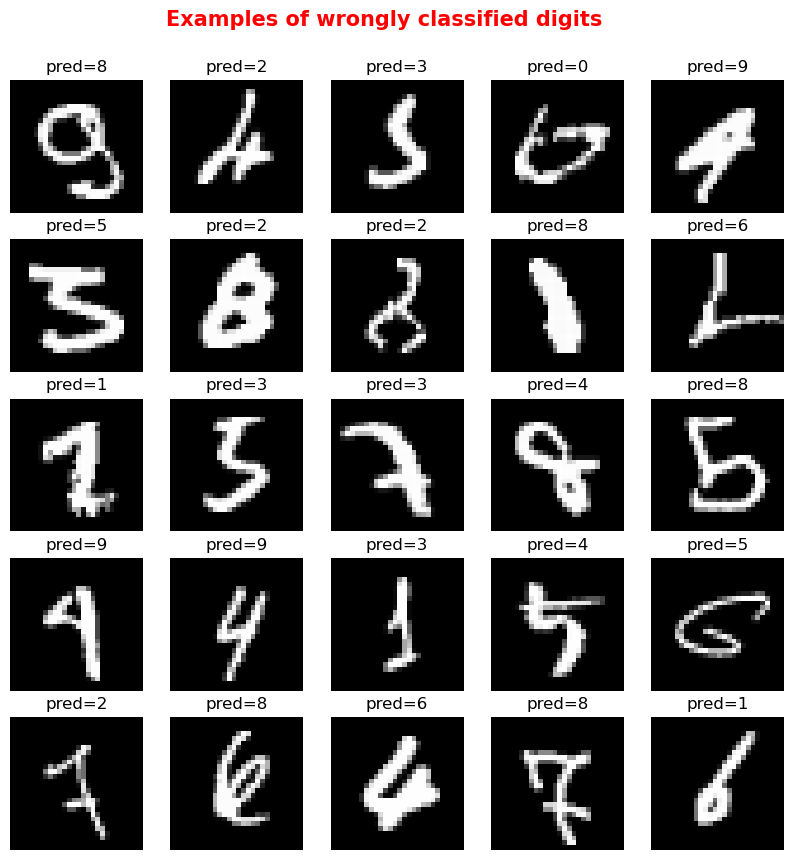

In [8]:
plt.figure()
show_img_grid(
    [test_images[idx].reshape((28, 28)) for idx in error_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in error_idxs[:25]],
)
plt.suptitle("Examples of wrongly classified digits",
             y=0.95, fontsize=15, c='r', fontweight="bold")